### Run once, to check environment

In [1]:
#!pip3 install -r requirements.txt

### Download Data, put under root directory DM-project/

https://msnews.github.io/behaviors

### Scraper part, no need to run, just in case, can be adapted to other datasource
   * Scraping publish time of news
   * To run it, put 'MINDlarge_train' in the top level directory of the project, which is 'DM-project'
   * don't submit MINDlarge_train, add it to gitignore
   * Output filepath is 'DM-project/generate/newstimes.csv
   * Don't forget to go back to the top level directory
   

In [1]:
#%cd scraper

In [2]:
#!scrapy crawl news

In [3]:
#%cd ..

In [4]:
#newsTimes = 'generate/newstimes.csv'

### Load Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Preprocssing, run once

In [6]:
#from preprocessing.preprocessing import createNews,createUsers,splitFiles,createCategoriyEmbeddingNLP

In [7]:
#behaviors = 'MINDlarge_train/behaviors.tsv'
news = 'MINDlarge_train/news.tsv'
#entityEmbedding = 'MINDlarge_train/entity_embedding.vec'
##generate news_embedding.csv, news_cleaned.csv
#createNews(news,newsTimes,entityEmbedding)
##generate user_history.csv, user_impression.csv
#createUsers(behaviors)
##split big files
#splitFiles('generate/user_history.csv')
#splitFiles('generate/user_impressions.csv')

### No need to run, already generated, but in case you want to play around.
  * generate/news_subcat_embedding_nlp.csv

In [8]:
#!pip3 install spacy

In [9]:
#!python3 -m spacy download en_core_web_lg

In [10]:
#subcategories = "generate/news_subcategories.csv"
#createCategoriyEmbeddingNLP(subcategories)"

In [11]:
from analysis.measurement import measurement,baselineTest,baselineTestAvg,tuningParameters
from analysis.clustering import clusteringBatch
from analysis.recommendation import searchKNearestNeighbors

In [12]:
t0 = 1575586800+1000
lam = 0.01
threshold = 0.6

#distance bound by radius_scale*std of cluster 
default_radius = 0.3
radius_scale = 1

history = 'generate/user_history_1.csv'
impression = 'generate/user_impressions_1.csv'

### User representation
* clusteringBatch 
     -  group user by UID
     -  perform ward clustering on each user's reading history
     -  sample 3 cluster according to the Importance Scores
     -  calculate the medoid/centroid as one of representation of user's interest
     -  calculate accepted boundary(radius) for each cluster

In [15]:
df_user_representation_medoid,df_user_representation_centroid = clusteringBatch(t0,history=history,threshold=threshold,lam=lam,default_radius=default_radius,radius_scale=radius_scale,with_centroid=True)

<AxesSubplot:>

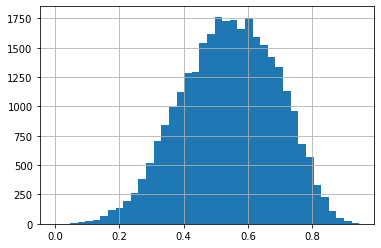

In [16]:
df_user_representation_centroid[~(df_user_representation_centroid.radius==default_radius)].radius.hist(bins=40)

* measurement
  - compare user representation(n by 300) with user impression(m by 300) 
  - get n by m distance matrix
  - mask distance matrix with accepted boundary
  - count recall for each positive impression, divide by length of impressions
  - count hits for each representation, consider empty hits percentage."

In [ ]:
df_measure_centroid = measurement(df_user_representation_centroid,impression=impression)

In [6]:
mean_recall = df_measure_centroid.recall.mean()
empty_percent = df_measure_centroid.percent_empty.mean()
print("If use centroids as user representation, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))



If use centroids as user representation, get recall 0.56, the percentage of empty recommendation is 0.56


In [7]:
df_measure_medoid = measurement(df_user_representation_medoid,impression=impression)

In [8]:
mean_recall = df_measure_medoid.recall.mean()
empty_percent = df_measure_medoid.percent_empty.mean()
print("If use medoids as user representation, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))
      
      

If use medoids as user representation, get recall 0.50, the percentage of empty recommendation is 0.60


### Baseline Test
   * randomly draw 3 news from history
   * pick the latest 3 news from history

In [9]:
df_user_representation_random,df_user_representation_latest = baselineTest(history,default_radius=default_radius)



In [10]:
df_measure_random = measurement(df_user_representation_random,impression=impression)

In [11]:
mean_recall = df_measure_random.recall.mean()
empty_percent = df_measure_random.percent_empty.mean()
print("If randomly draw 3 samples, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If randomly draw 3 samples, get recall 0.19, the percentage of empty recommendation is 0.84


In [12]:
df_measure_lastest = measurement(df_user_representation_latest,impression=impression)

In [13]:
mean_recall = df_measure_lastest.recall.mean()
empty_percent = df_measure_lastest.percent_empty.mean()
print("If draw 3 latests samples, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If draw 3 latests samples, get recall 0.19, the percentage of empty recommendation is 0.83


In [12]:
df_user_represent_avg = baselineTestAvg(history)

In [13]:
df_measure_avg = measurement(df_user_represent_avg,impression=impression)

In [14]:
mean_recall = df_measure_avg.recall.mean()
empty_percent = df_measure_avg.percent_empty.mean()
print("If use mean of user history as representation, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If use mean of user history as representation, get recall 0.19, the percentage of empty recommendation is 0.58


### Parameter tuning
* $\lambda$ for importance score
* threshold for ward clustering
* measureed by recall and hits

In [ ]:
lams = [0.01]
thresholds = [0.5, 0.75, 1.0, 1.25, 1.50, 2.0, 3.0, 4.0, 5.0]
df_tuning_result = tuningParameters("12",lam=lams,threshold=thresholds)

In [ ]:
df_tuning_result.head()

In [ ]:
df_tuning_result.to_csv("generate/threshold_tuning.csv")

### Recommendation System--Hierarchical Navigable Small World
* 89222 elements in space, with 100 dimensions.
* Search 4 nearest neighbor for each item of user representation

In [14]:
import time

t_before = time.perf_counter()
df_recommendation = searchKNearestNeighbors(df_user_representation_centroid,k=4)
print(f'Time cost {time.perf_counter()-t_before} s')

Time cost 29.314773647999914 s


In [15]:
df_news_meta = pd.read_csv(news,sep='\t',header=None)
df_news_meta.rename(columns={0:'NID',1:'category',2:'subcategory',3:'title',4:'abstract',6:'title_entities',7:'abstract_entities'},inplace=True)
df_news_meta = df_news_meta[['NID','category','subcategory','title','abstract','title_entities','abstract_entities']]
  

In [16]:
UID = df_recommendation.sample().UID.values[0]

df_recommendation[df_recommendation.UID==UID].merge(df_news_meta,on='NID')

,UID,NID,category,subcategory,title,abstract,title_entities,abstract_entities
0,U378649,N11793,finance,finance-companies,The world's only $100 billion utility owes its...,"Two decades ago, when coal ruled U.S. power ge...",[],"[{""Label"": ""Florida"", ""Type"": ""G"", ""WikidataId..."
1,U378649,N61505,weather,weathertopstories,In case you missed it: Winterlike storm trigge...,Snow hasn't gotten the memo that might be a li...,"[{""Label"": ""United States"", ""Type"": ""G"", ""Wiki...","[{""Label"": ""California"", ""Type"": ""G"", ""Wikidat..."
2,U378649,N59231,finance,markets,"Migrants Find Different Fates at Texas, Arizon...","Across most of the southern U.S. border, hundr...","[{""Label"": ""Arizona"", ""Type"": ""G"", ""WikidataId...","[{""Label"": ""Arizona"", ""Type"": ""G"", ""WikidataId..."
3,U378649,N8262,sports,more_sports,Manatee County Army Veteran soon to be inducte...,"After years of serving America, then retiring ...","[{""Label"": ""Florida"", ""Type"": ""G"", ""WikidataId...","[{""Label"": ""Manatee County, Florida"", ""Type"": ..."
4,U378649,N83203,news,newsworld,Lebanon Uber driver gets death sentence for mu...,A Lebanese court sentenced Uber driver Tariq H...,[],"[{""Label"": ""News agency"", ""Type"": ""C"", ""Wikida..."
5,U378649,N78589,finance,finance-savemoney,5 Ways to Trim the Growing Cost of Cutting the...,Streaming TV services can run you more than tr...,[],"[{""Label"": ""Streaming television"", ""Type"": ""N""..."
6,U378649,N15594,news,newsscienceandtechnology,How to cut cable's cord and go streaming in 2019,Dropping cable TV and watching television and ...,[],"[{""Label"": ""Streaming television"", ""Type"": ""N""..."
7,U378649,N129013,tv,tv-gallery,"Streaming TV Scorecard: Renewals, Cancellation...",NaN,"[{""Label"": ""Streaming television"", ""Type"": ""N""...",[]
8,U378649,N82792,sports,football_nfl,NFL Odds: How Likely Is Dez Bryant-Patriots Pa...,It sounds like Dez Bryant wants to play footba...,"[{""Label"": ""Dez Bryant"", ""Type"": ""P"", ""Wikidat...","[{""Label"": ""Dez Bryant"", ""Type"": ""P"", ""Wikidat..."
9,U378649,N4937,sports,football_nfl,Seahawks' Jadeveon Clowney named NFC Defensive...,Jadeveon Clowney's dominating performance was ...,"[{""Label"": ""Jadeveon Clowney"", ""Type"": ""P"", ""W...","[{""Label"": ""Jadeveon Clowney"", ""Type"": ""P"", ""W..."


In [17]:
df_history = pd.read_csv(history)
df_history = df_history[df_history.UID==UID].merge(df_news_meta,on='NID')
df_history

,UID,NID,category,subcategory,title,abstract,title_entities,abstract_entities
0,U378649,N1396,news,newsopinion,The News In Cartoons,News as seen through the eyes of the nation's ...,[],[]
1,U378649,N122729,movies,movies-celebrity,'Game of Thrones': 'Avengers' Elizabeth Olsen ...,Elizabeth Olsen said she auditioned for Khalee...,"[{""Label"": ""Elizabeth Olsen"", ""Type"": ""P"", ""Wi...","[{""Label"": ""Elizabeth Olsen"", ""Type"": ""P"", ""Wi..."
2,U378649,N124453,music,music-celebrity,"Renowned DJ Zedd ""Permanently Banned"" From Chi...",The Comedy Central cartoon has been banned by ...,"[{""Label"": ""South Park"", ""Type"": ""W"", ""Wikidat...","[{""Label"": ""Government of China"", ""Type"": ""O"",..."
3,U378649,N63723,news,newsus,Texas police officer shoots woman to death ins...,A Fort Worth police officer checking out a res...,"[{""Label"": ""Texas"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Fort Worth Police Department"", ""Ty..."
4,U378649,N116312,sports,more_sports,Patrick Day in coma after suffering brutal kno...,The junior middleweight underwent emergency br...,[],[]
...,...,...,...,...,...,...,...,...
86,U378649,N59700,sports,football_nfl,Jimmy Garoppolo addresses Erin Andrews intervi...,NaN,"[{""Label"": ""Erin Andrews"", ""Type"": ""P"", ""Wikid...",[]
87,U378649,N85531,sports,football_nfl,"After Thursday morning rant, Antonio Brown bac...",Brown took to social media Thursday morning wi...,"[{""Label"": ""Antonio Brown"", ""Type"": ""P"", ""Wiki...","[{""Label"": ""Antonio Brown"", ""Type"": ""P"", ""Wiki..."
88,U378649,N63367,sports,football_nfl,Jon Gruden falls to 0-for-7 on challenges with...,NaN,"[{""Label"": ""Jon Gruden"", ""Type"": ""P"", ""Wikidat...",[]
89,U378649,N66776,news,newsus,Officials responding to oil spill from cargo s...,The U.S. Coast Guard says a cargo ship has spi...,"[{""Label"": ""Hawaii"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Honolulu Harbor"", ""Type"": ""U"", ""Wi..."
